# Evolutionary Robot Path Planning

## Introduction
Robotic path planning is an important problem in the Robotics field with many available solutions. One of these options is the use of a genetic
algorithm to find the optimal path for the robot to take.

In this demo, the robot is given target coordinates which it must travel to while avoiding any obstacles in the way. The optimal path for the robot 
is the path that brings it to the target coordinates in as few steps as possible. 
The robot make its way to the target coordinates in steps of maximum distance x, and is equipped with a distance sensor to detect obstacles
within a set view distance, so it can adjust its path accordingly.

In [176]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from shapely import LineString, MultiLineString, MultiPolygon, Point, clip_by_rect, box, affinity
from shapely.plotting import plot_polygon, plot_line
from IPython.display import clear_output
from time import sleep

# Environment Obstacles
The environment the robot must navigate is filled with obstacles. Obstacles, which are rectangular in shape, can represent impassable objects, such 
as walls, or traversable objects  which may slow the robot down, representing different types of terrain.

In [177]:
class Obstacle:

    def __init__(self, xlim: tuple, ylim: tuple, permeability=1, velocity=(0, 0)):
        self.xlim = np.array(xlim)
        self.ylim = np.array(ylim)
        self.shape = box(xlim[0], ylim[0], xlim[1], ylim[1])
        self.permeability = permeability
        self.velocity = velocity

    def update_position(self):
        self.xlim += self.velocity[0]
        self.ylim += self.velocity[1]


An ``Obstacle`` is initialized by providing the range of x values it covers, the range of y values, and optionally, the permeability and velocity.
The first x and first y values together represent the bottom left coordinates of the obstacle, while the last two represent the top right.

The permeability of the obstacle defined how "passable" the object is, where a permeability of 1 is impassable, like a wall, and a permeability of 
zero would be as if there was no object at all.

TODO: Talk about velocity

The ``Obstacle`` class above also has a ``shape`` property, which stores a box polygon from the Shapely library, allowing for easier geometric 
calculations with the many shapes of the simulation.

Below, you can see how different obstacles are defined and rendered in the environment.

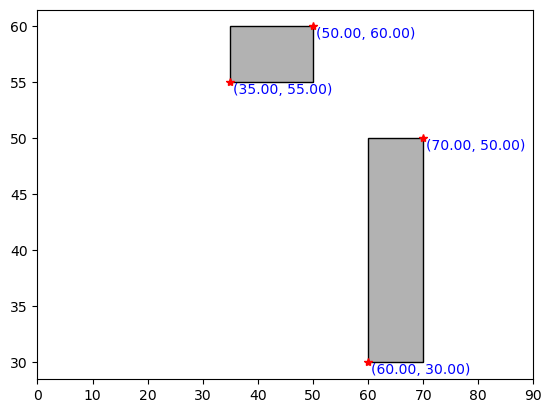

In [178]:
fig, ax = plt.subplots()
ax.set_xlim(0, 90)
# Define obstacles with bottom left coordinates: (35, 55) and (60, 30)
# and top right: (50, 60) and (70, 50)
obstacles = (Obstacle((35, 50), (55, 60)), Obstacle((60, 70), (30, 50)))
# A Shapely MultiPolygon object is created to store the collection of obstacles
obstaclesShapely = MultiPolygon([obs.shape] for obs in obstacles)
# Shapely helper function plot_polygon 
# adds the MultiPolygon collection to the plot
plot_polygon(obstaclesShapely, ax=ax, color='black', add_points=False)
for obstacle in obstacles:
    for xy in zip(obstacle.xlim, obstacle.ylim): 
        # Show bottom left and top right coords of obstacles
        ax.plot(xy[0], xy[1], 'r*')
        plt.annotate('(%.2f, %.2f)' % xy, xy=(xy[0]+0.5, xy[1]-1), color='blue')

# Robot Agent
The robot is initialized with a starting location, target coordinates, and optionally parameters for the view distance of the sensors, 
the step distance, and the turning angle of the robot.

During each step, the robot must first calculate the next waypoint. It starts with an ideal waypoint, which is a direct path the length of the 
view distance towards the target coordinate, regardless of obstacles. Then, the robot checks if the path intersects with an obstacle and if it does, 
it adjusts by rotating the path a random amount of degrees until there is no collision.

The view distance is used for this calculation instead of the step distance so obstacles even outside of the step range are considered, potentially 
resulting in fewer steps to the final target.

Once a satisfactory path is found, the robot location is updated to the point on the path equal to the step distance from its previous location.

In [179]:
class Robot:
    """Agent class representing the robot."""

    def __init__(self, loc, target, params):
        """Initializes the attributes.
        loc: tuple(x,y) representing robots current/start coordinates
        fit_land: FtinessLandscape object
        target: tuple(x,y) representing target coordinates
        """
        self.loc = Point(loc)
        self.target = Point(target)
        self.obstacles = MultiPolygon()
        self.artists = []

        # Sensor and actuator params
        self.view_distance = params.get('view_distance', 10) # Must be >= step_distance
        self.step_distance = params.get('step_distance', 10)
        self.turn_angle = params.get('turn_angle', 180) # Max turning angle in degrees

        # Sensor and actuator values
        self.view = clip_by_rect(self.loc.buffer(self.view_distance), 0, 0, self.target.x, self.target.y)

        # History
        self.num_steps = 0
        self.pathHist = []

    def find_waypoint(self):
        """Returns the coordinates for the next motion as a Point object.

        TODO: Doesn't necessarily have to always go full distance,
        maybe edit so step_distance is treated as the max travel distance 
        rather than the distance for every step
        """

        # Calculate ideal waypoint as straight line from robot towards target
        # Using view_distance so it calculates based what it sees beyond where it can move
        idealWaypoint = LineString([self.loc, self.target]).interpolate(self.view_distance)
        idealPath = LineString([self.loc, idealWaypoint])

        path = idealPath
        rng = np.random.default_rng()

        # If the chosen path intersects with a detected obstacle, rotate the path a random amount up to self.turn_angle degrees
        while self.obstacles.intersects(path):
            path = affinity.rotate(path, rng.integers(self.turn_angle), (self.loc.x, self.loc.y))


        return path.interpolate(self.step_distance)
    
    def step(self, env):
        """Performs motion to next calculated waypoint and updates history."""
        next = self.find_waypoint()
        path = LineString([self.loc, next])
        self.pathHist.append(path) 
        self.loc = next
        self.view = clip_by_rect(self.loc.buffer(self.view_distance), 0, 0, env.size[0], env.size[1])
        self.obstacles = env.detect_obstacles(self)
        self.num_steps += 1
        
    def draw(self, ax):
        """Plotsthe robot path."""

        # If robots have different targets or start points, uncomment
        #ax.plot(self.loc.x, self.loc.y, 'bX', markersize=7, zorder=100)
        #ax.plot(self.target.x, self.target.y, 'r*', markersize=10)

        self.artists.clear()
        hist = MultiLineString(self.pathHist)
        
        container = ax.plot(self.loc.x, self.loc.y, 'o', markersize=7, zorder=100, color='darkorange')
        self.artists.append(container)
        container = plot_line(hist, ax=ax, linestyle=':', ec='black', color='lightblue')
        self.artists.append(container[0])
        container = plot_polygon(self.obstacles, ax=ax, color=(1, 0, 0, 1), add_points=False)
        self.artists.append(container)
        container = plot_polygon(self.view, ax=ax, add_points=False, linestyle='--', edgecolor='red', facecolor=(0,0,0,0))
        self.artists.append(container)

        return self.artists
    

The code below shows how a robot is initialized and plots its path as shown on the plot.

[[<matplotlib.lines.Line2D at 0x2228cbe5ee0>],

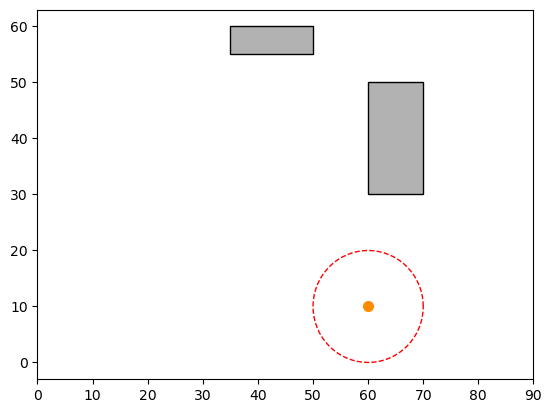

In [180]:
fig, ax = plt.subplots()
ax.set_xlim(0, 90)
# Create obstacles as before
obstacles = (Obstacle((35, 50), (55, 60)), Obstacle((60, 70), (30, 50)))
obstaclesShapely = MultiPolygon([obs.shape] for obs in obstacles)
plot_polygon(obstaclesShapely, ax=ax, color='black', add_points=False)

robot = Robot((60,10), (90, 90), dict())
robot.draw(ax)


The orange dot represents the robots current location and the dotted red circle shows the view distance of the robot.
Currently, the robot has no knowledge of any obstacles, so it should calculate the next waypoint as a straight line towards the 
target location ``(90, 90)``.

# Simulation
The environment data is stored in the ``Simulation`` class. For intialization, this class requires a size tuple (width, height), 
a starting coordinate for the robots, and the target coordinate. Optionally, the number of robots to spawn can also be set.

All agents and obstacles in the environment are tracked. A ``detect_obstacles`` function has been added to the class, and is called by the robot to 
get polygons from the overlap of the robots view distance and the obstacles in the environment. The robot stores these polygons and uses them for 
waypoint calculation.

This class also includes the ``animation`` and ``run_full`` functions which animate the dynamic elements, such as the robot path and view distance, and steps continually until the target coordinate is reached for all robots.

In [181]:

class Simulation:
    
    def __init__(self, size: tuple, start : tuple, objective: tuple, num_agents=10):
        self.size = size
        self.start = start
        self.objective = objective
        self.num_agents = num_agents

        self.agents = []
        self.obstacles = []

        self.fig, self.ax = plt.subplots()

    def run():
        # Create agents here?
        # Find optimal path
        pass
        
    def add_obstacles(self, obstacles):
        self.obstacles.extend(obstacles)

    def draw_path(self, path):
        # Keeping this general for now - could take in the agent instead of the path in the future
        # Path format can also be changed

        # Setup figure and axis
        fig, ax = plt.subplots()
        fig.set_size_inches((7, 7))
        ax.set_xlim(0, self.size[0])
        ax.set_ylim(0, self.size[1])
        ax.set_axis_off()

        # Start and objective
        ax.plot(self.start[0], self.start[1], 'bX', markersize=7)
        ax.plot(self.objective[0], self.objective[1], 'r*', markersize=10)

        # Obstacles
        for obs in self.obstacles:
            ax.add_patch(patches.Rectangle((obs.xlim[0], obs.ylim[0]), obs.xlim[1] - obs.xlim[0], obs.ylim[1] - obs.ylim[0],
                                           color='black', alpha=obs.permeability))

        # Path
        for i, pos in enumerate(path[:-1]):
            next_pos = path[i+1]
            ax.plot((pos[0], next_pos[0]), (pos[1], next_pos[1]), 
                     linestyle='--', marker='.', color='black', mfc='blue', mec='blue', markersize=7)
            
    def detect_obstacles(self, robot: Robot):
        """Returns polygons representing visible parts of obstacles to robot.
        TODO: Should robot remember past detected obstacles? So if it revisits an area it would already know of the obstacle
        """
        return MultiPolygon([obs.shape.intersection(robot.view) for obs in self.obstacles])
    
    def add_agent(self):
        new_agent = Robot(self.start, self.objective, dict())
        self.agents.append(new_agent)
    
    def remove_agents(self):
        self.agents.clear()

    def step(self):
        for agent in self.agents:
            agent.step(self)

    def draw(self):
        """Plots obstacles, start/target coords, and path/view of each robot"""
        self.ax.set_xlim(0, self.size[0])
        self.ax.set_ylim(0, self.size[1])

        obstacles = MultiPolygon([obs.shape] for obs in self.obstacles)
        plot_polygon(obstacles, ax=self.ax, color='black', add_points=False)
        self.ax.plot(self.start[0], self.start[1], 'bX', markersize=7, zorder=10)
        self.ax.plot(self.objective[0], self.objective[1], 'r*', markersize=10)

    def animate(self):
        # Remove previous artists for rerender
        # TODO: If multiple robots, should we give them and their paths different colours/shades?
        [[artist.remove() if type(artist) is not list else artist[0].remove() for artist in robot.artists] for robot in self.agents]
        artists = ([robot.draw(self.ax) for robot in self.agents])
        return artists

    def run_full(self):
        """Run simulation and plot every 1s until all robots reach target"""
        self.draw()
        while any([robot.loc != robot.target for robot in self.agents]):  
            self.animate()
            display(self.fig)
            sleep(0.5)
            self.step()
            clear_output(wait=True)
        
        clear_output()
        self.animate()
        display(self.fig)
        
            

Using the same obstacles and start/target coordinates from before, the Simulation class plots the environment and current robot status.

[[[<matplotlib.lines.Line2D at 0x2228bb31e80>],

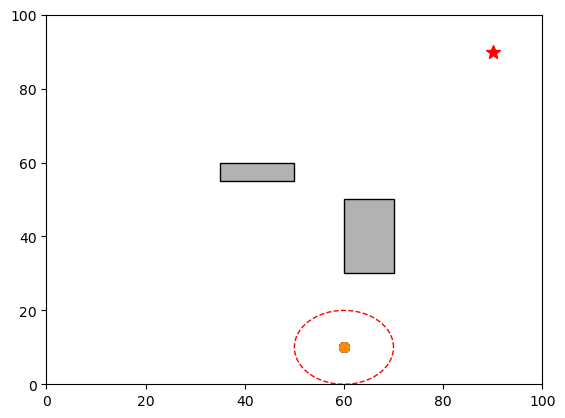

In [ ]:
start = (60, 10)
objective = (90, 90)
obstacles = (Obstacle((35, 50), (55, 60)), Obstacle((60, 70), (30, 50)))

sim = Simulation((100, 100), start, objective)
sim.add_obstacles(obstacles)
sim.add_agent() # Add one robot

sim.draw() # Draws environment and start/target
sim.animate() # Calls robots draw function

If we call the step function, we can see the robots chosen waypoint is directly towards the target since there are no obstacles in its viewpoint.

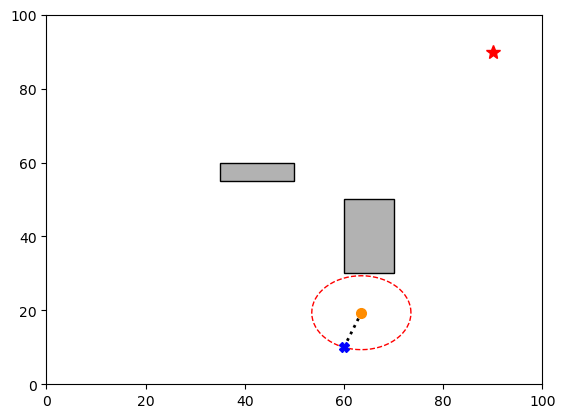

In [183]:
sim.step()
sim.animate()
display(sim.fig)

After the next step, the obstacle detected by the robot is shaded red. The robot only knows of what is in its view distance, so it only 
sees the red part of the obstacle.

Since this obstacle is in the way of the ideal path, the robot must adjust its route.

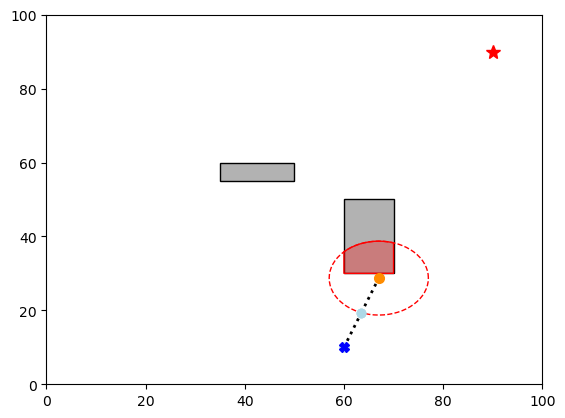

In [184]:
sim.step()
sim.animate()
display(sim.fig)

We can use the ``run_full`` function to show how the robot finds a path all the way to the target, avoiding any detected obstacles on the way.

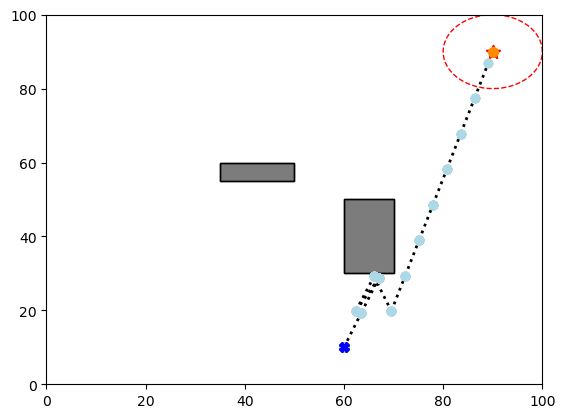

In [ ]:
sim.run_full()

If we add multiple robots, the robot behavior in response to obstacles becomes clearer.

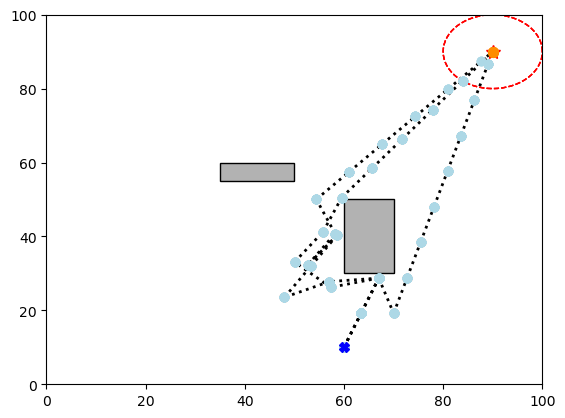

In [186]:
# Clear all agents to reset sim
sim.remove_agents()
# Clear plot
sim.ax.clear()

# Add three fresh agents
for _ in range(3):
    sim.add_agent()

sim.run_full()